# Setup

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install meteostat
%pip install scikit-learn
%pip install xgboost
%pip install plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from calendar import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


# Data Cleaning

First it's necessary to ensure that all of the data types match for each of the columns, converting to them from strings. All of the weather logic was done in the `weather_data_collector.py` file.

In [41]:
mtl_centre_coords = (45.504376,-73.555919) #Coords for center of old city (Notre-Dame)

bixi_2023 = pd.read_csv('C:\\Users\\histo\\individual_project_3125_bixi\\COMP_3125_Individual_Project_AidenDever\\data\\Bixi_2023_weather.csv')
population_df = pd.read_csv('C:\\Users\\histo\\individual_project_3125_bixi\\COMP_3125_Individual_Project_AidenDever\\data\\arrondisement_population.csv')

#Clean up data and insure correct formatting for analysis later
bixi_2023['STARTTIME'] = pd.to_datetime(bixi_2023['STARTTIMEMS'], unit='ms')
bixi_2023['ENDTIME'] = pd.to_datetime(bixi_2023['ENDTIMEMS'], unit='ms')

bixi_2023['trip_length_minutes'] = (pd.to_numeric(bixi_2023['ENDTIMEMS']) - pd.to_numeric(bixi_2023['STARTTIMEMS'])) * 60000
bixi_2023['startstation_count'] = bixi_2023.groupby('STARTSTATIONARRONDISSEMENT')['STARTSTATIONNAME'].transform('nunique')
bixi_2023['Month of Year'] = bixi_2023['STARTTIME'].dt.month
bixi_2023['hour_of_day'] = bixi_2023['STARTTIME'].dt.hour

bixi_2023['distance_to_center'] = np.sqrt(
    ((pd.to_numeric(bixi_2023['STARTSTATIONLATITUDE']) - mtl_centre_coords[0]) * 111) ** 2 +
    ((pd.to_numeric(bixi_2023['STARTSTATIONLONGITUDE']) - mtl_centre_coords[1]) * 111 * np.cos(np.radians(mtl_centre_coords[0]))) ** 2
)
bixi_2023 = pd.merge(bixi_2023, population_df, left_on='STARTSTATIONARRONDISSEMENT', right_on='Neighborhood', how='left')

# Mapping of meteostat coco weather codes to weather conditions
# https://dev.meteostat.net/formats.html
weather_mapping = {
    1: "Clear", 2: "Fair", 3: "Cloudy", 4: "Overcast", 5: "Fog", 
    6: "Freezing Fog", 7: "Light Rain", 8: "Rain", 9: "Heavy Rain", 
    10: "Freezing Rain", 11: "Heavy Freezing Rain", 12: "Sleet", 
    13: "Heavy Sleet", 14: "Light Snowfall", 15: "Snowfall", 
    16: "Heavy Snowfall", 17: "Rain Shower", 18: "Heavy Rain Shower", 
    19: "Sleet Shower", 20: "Heavy Sleet Shower", 21: "Snow Shower", 
    22: "Heavy Snow Shower", 23: "Lightning", 24: "Hail", 
    25: "Thunderstorm", 26: "Heavy Thunderstorm", 27: "Storm"
}

bixi_2023['Weather Category'] = pd.to_numeric(bixi_2023['COCO'], errors='coerce').astype('Int64')
# Map numeric codes to descriptive text
bixi_2023['Weather Category'] = bixi_2023['Weather Category'].map(weather_mapping)

# print(bixi_2023.columns)

# Analysis

Defines the ```arrondisement_stats``` dataset, a dataset that contains metrics for every arrondisement in the BIXI dataset. Population is unique for every arrondisement, but is technically aggregated to avoid unecessary merges later on.

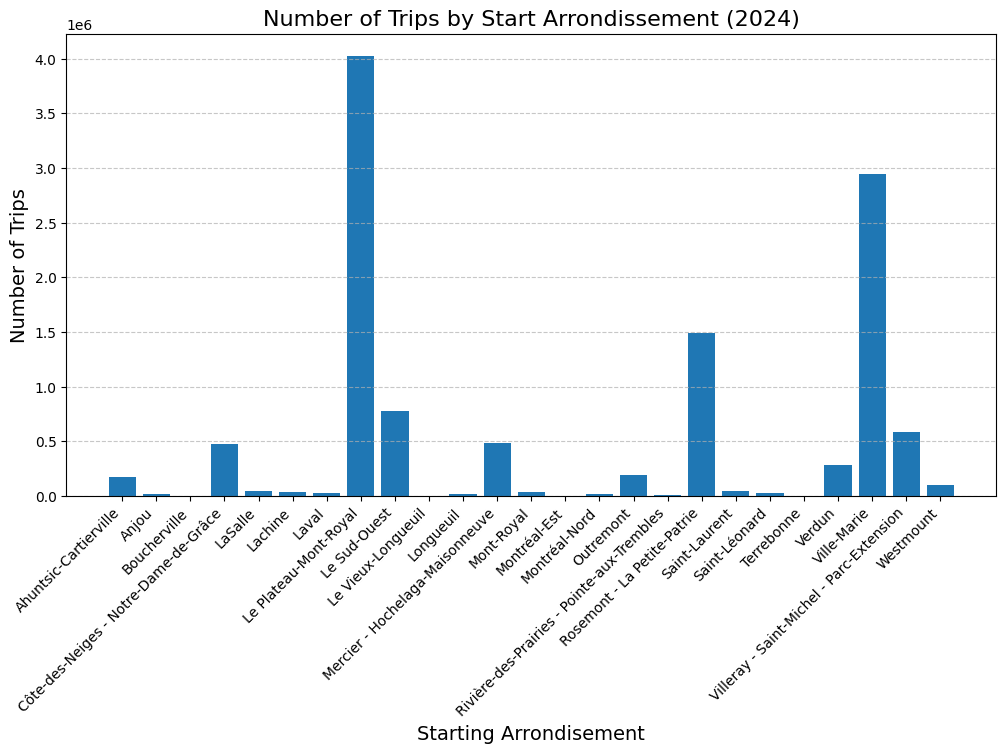

In [42]:
# Group data by start station arrondisement
arrondisement_stats = bixi_2023.groupby('STARTSTATIONARRONDISSEMENT').agg(
    num_trips=('STARTSTATIONNAME', 'count'),
    num_unique_stations=('STARTSTATIONNAME', 'nunique'),
    arrondisement_population=('Population', 'mean'),
    median_trip_length=('trip_length_minutes', 'median')
).reset_index()

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(arrondisement_stats['STARTSTATIONARRONDISSEMENT'], arrondisement_stats['num_trips'])
plt.title('Number of Trips by Start Arrondissement (2024)', fontsize=16)
plt.xlabel('Starting Arrondisement', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()

We see that a few arrondisements have a significantly higher number of trips, namely the Plateau and Ville-Marie. Both are trendier areas with better bike infrastructure than the rest of the city. The suburbs/off island stations (Laval/Longueuil) both have lower ridership numbers, indicating that most Bixi customers are centered on the island. It's understandable that few people bike in Longeuil, since it's very difficult to access from Montreal by bike without going a roundabout way across L'Ile Sainte-Helene.

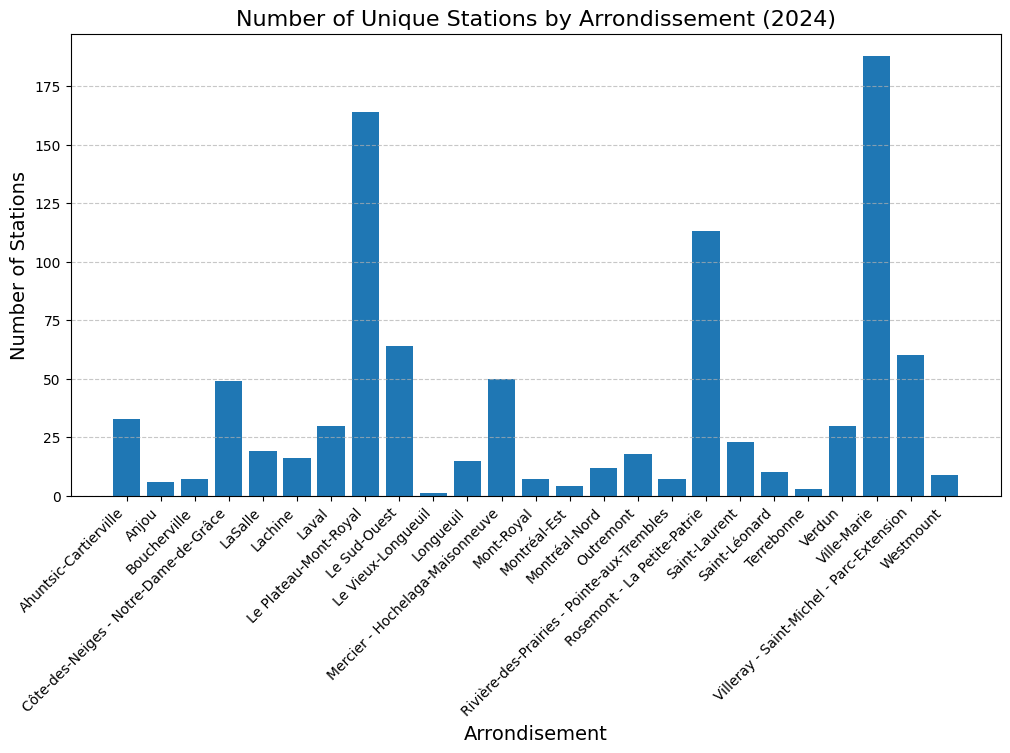

In [43]:
# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(arrondisement_stats['STARTSTATIONARRONDISSEMENT'], arrondisement_stats['num_unique_stations'])
plt.title('Number of Unique Stations by Arrondissement (2024)', fontsize=16)
plt.xlabel('Arrondisement', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()

This roughly lines up with the other bar chart above, indicating that Bixi tends to put more stations in areas with higher ridership, which makes sense. This however, does flatten out some of the spikes that we saw with the number of trips bar chart. The suburbs/off island arrondisements are more represented here. This indicates that operations here may not be as cost effective as they are on-island.

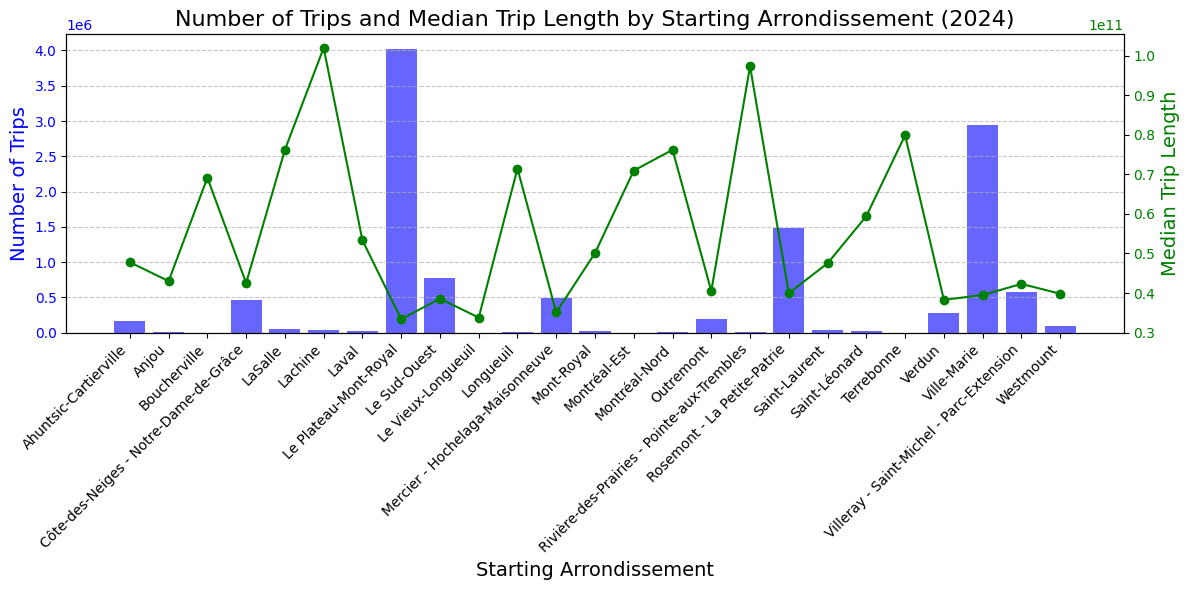

In [44]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for num_trips (primary y-axis)
ax1.bar(arrondisement_stats['STARTSTATIONARRONDISSEMENT'], arrondisement_stats['num_trips'], color='b', alpha=0.6, label='Number of Trips')
ax1.set_xlabel('Starting Arrondissement', fontsize=14)
ax1.set_ylabel('Number of Trips', fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for median_trip_length
ax2 = ax1.twinx()
ax2.plot(arrondisement_stats['STARTSTATIONARRONDISSEMENT'], arrondisement_stats['median_trip_length'], color='g', marker='o', label='Median Trip Length')
ax2.set_ylabel('Median Trip Length', fontsize=14, color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Number of Trips and Median Trip Length by Starting Arrondissement (2024)', fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

This chart is very interesting, and suggests an inverse relationship between number of trips and trip length. Higher ridership arrondisements tend to have lower trip lengths. This could be for a variety of reasons, but most of these seem to relate to how far away they are from Ville-Marie (downtown Montreal). Lower ridership but higher trip length stations tend to be on the outskirts of the city, but not off-island. Perhaps distance from the center of Montreal would be a good additional feature for our prediction model later.

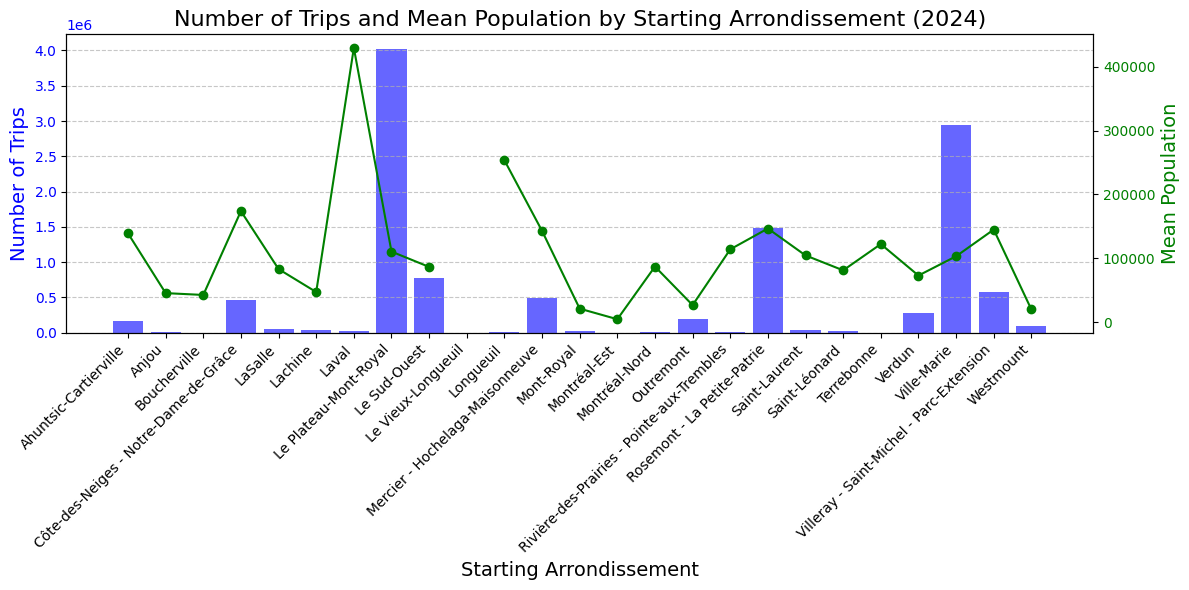

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for num_trips (primary y-axis)
ax1.bar(arrondisement_stats['STARTSTATIONARRONDISSEMENT'], arrondisement_stats['num_trips'], color='b', alpha=0.6, label='Number of Trips')
ax1.set_xlabel('Starting Arrondissement', fontsize=14)
ax1.set_ylabel('Number of Trips', fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for arrondisement_population
ax2 = ax1.twinx()
ax2.plot(arrondisement_stats['STARTSTATIONARRONDISSEMENT'], arrondisement_stats['arrondisement_population'], color='g', marker='o', label='Arrondisement Population')
ax2.set_ylabel('Mean Population', fontsize=14, color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Number of Trips and Mean Population by Starting Arrondissement (2024)', fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right') 

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

This chart does not tell us too much about any sort of pattern. Heavy additional filtering would be necessary for this to be useful to any training model. For instance, while ridership in Longeuil and Laval are significantly lower than their population suggests, these two suburbs also both have less stations. Additionally, biking to downtown Montreal from these off-island suburbs is difficult, as crossing the Saint-Lawrence River by bike is not easy.

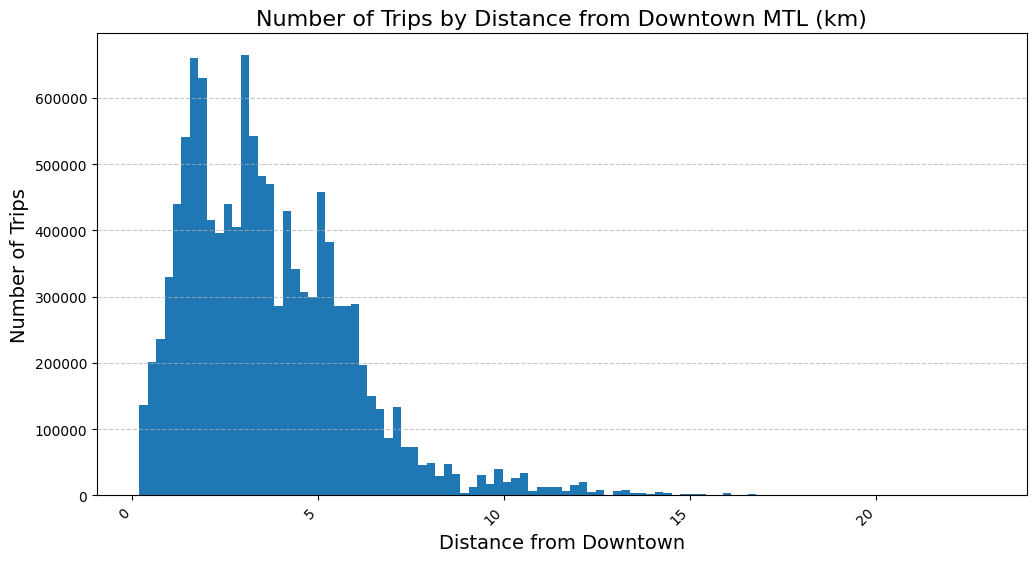

In [46]:

filtered_df = bixi_2023[bixi_2023['distance_to_center'] < 2000] # One or two data points with weird lat/long values

# Bar chart
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['distance_to_center'],bins=100)
plt.title('Number of Trips by Distance from Downtown MTL (km)', fontsize=16)
plt.xlabel('Distance from Downtown', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()

This feature could be very useful in our prediction model later. For stations farther away the station is from downtown, fewer trips originate from that station

C:\Users\histo\AppData\Local\Temp\ipykernel_13356\1809099576.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\histo\AppData\Local\Temp\ipykernel_13356\1809099576.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



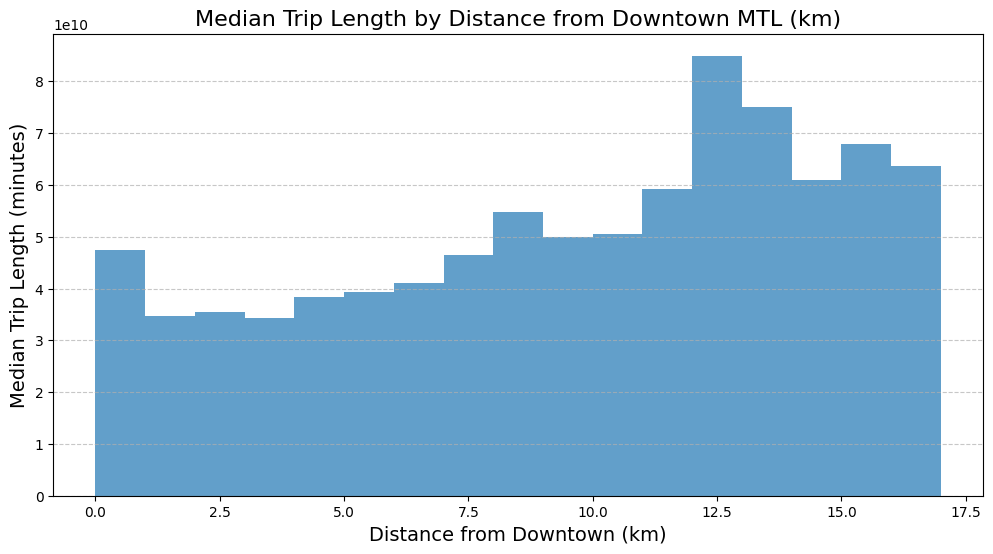

In [47]:
# Define bins for distance_to_center using strategy here: https://stackoverflow.com/questions/5328556/histogram-matplotlib
bins = np.linspace(0, 20, 21)
filtered_df['distance_bin'] = pd.cut(filtered_df['distance_to_center'], bins=bins)

# Group by distance bins and calculate the median trip length for each bin
bin_metrics = filtered_df.groupby('distance_bin')['trip_length_minutes'].median()

# Plot
plt.figure(figsize=(12, 6))
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2  # Calculate bin centers for plotting
plt.bar(bin_centers, bin_metrics, width=(bins[1] - bins[0]), align='center', alpha=0.7)

plt.title('Median Trip Length by Distance from Downtown MTL (km)', fontsize=16)
plt.xlabel('Distance from Downtown (km)', fontsize=14)
plt.ylabel('Median Trip Length (minutes)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

We can see that trip length increases as distance from downtown increases, which suggests that the bulk of Bixi traffic is commuter.

In [48]:

station_stats = bixi_2023.groupby('STARTSTATIONNAME').agg(
    start_station_latitude=('STARTSTATIONLATITUDE', 'mean'),
    start_station_longitude=('STARTSTATIONLONGITUDE', 'mean'),
    num_trips=('STARTSTATIONNAME', 'count'),
).reset_index()

fig = px.density_mapbox(
    station_stats,
    lat="start_station_latitude",
    lon="start_station_longitude",
    z="num_trips",
    radius=11,  # Adjust radius for spread
    center={"lat": 45.516267, "lon": -73.565072},
    zoom=12,  # Adjust zoom level
    mapbox_style="carto-positron",
)

fig.show()

This map shows how bixi stations become much more sparse towards the outer edges of Montreal, and become much more dense and evenly distributed downtown. In addition, the stations are much more heavily concentrated around tourist destinations like Parc la Fontaine, Mont-Royal, and the Vieux-Port.

Below, a one-off dataset ```monthly_agg``` is creted to see how ridership changes over the course of the year.

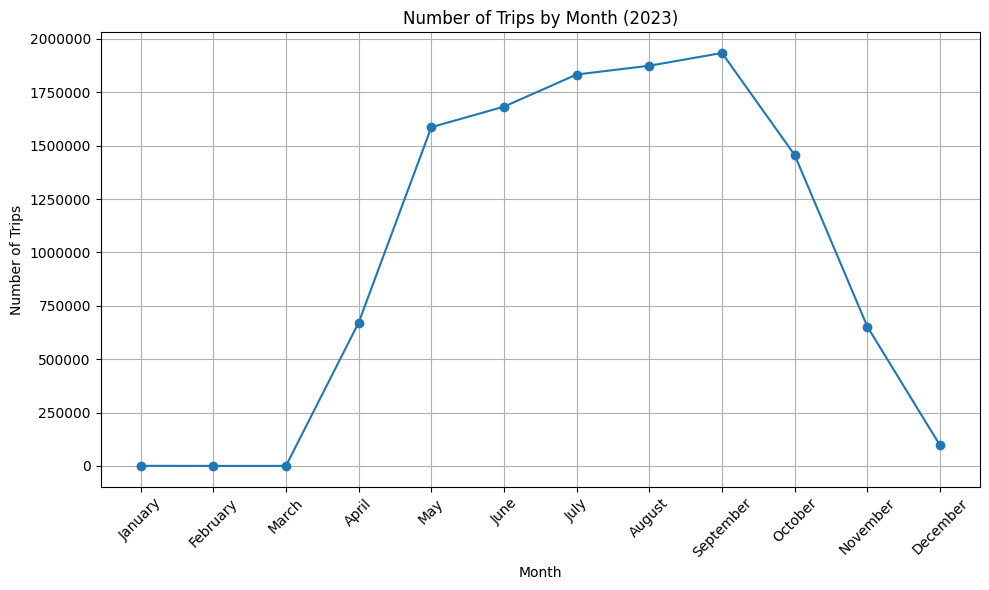

In [49]:
# Extract year and month
bixi_2023['month_start'] = bixi_2023['STARTTIME'].dt.month

monthly_agg = bixi_2023.groupby('month_start')['STARTSTATIONNAME'].count().reset_index()

# Include all months (1-12) by reindexing
all_months = pd.DataFrame({'month_start': range(1, 13)})  
monthly_agg = pd.merge(all_months, monthly_agg, on='month_start', how='left') 
monthly_agg['STARTSTATIONNAME'] = monthly_agg['STARTSTATIONNAME'].fillna(0)  # Fill missing counts with 0

# Plot a line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_agg['month_start'], monthly_agg['STARTSTATIONNAME'], marker='o')
plt.title('Number of Trips by Month (2023)')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.grid(True)

# Set x-axis labels as full month names
plt.xticks(
    ticks=monthly_agg['month_start'],
    labels=[calendar.month_name[m] for m in monthly_agg['month_start']],
    rotation=45
)
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.show()

Montreal gets a lot of snow in the winter, which can make bicycling very difficult in the winter. Starting in 2023/2024, Bixi started letting people rent bicycles at select stations in the winter. However we still see a sharp drop-off in the number of users, indicating that people are less willing to bike in the snow/cold weather.

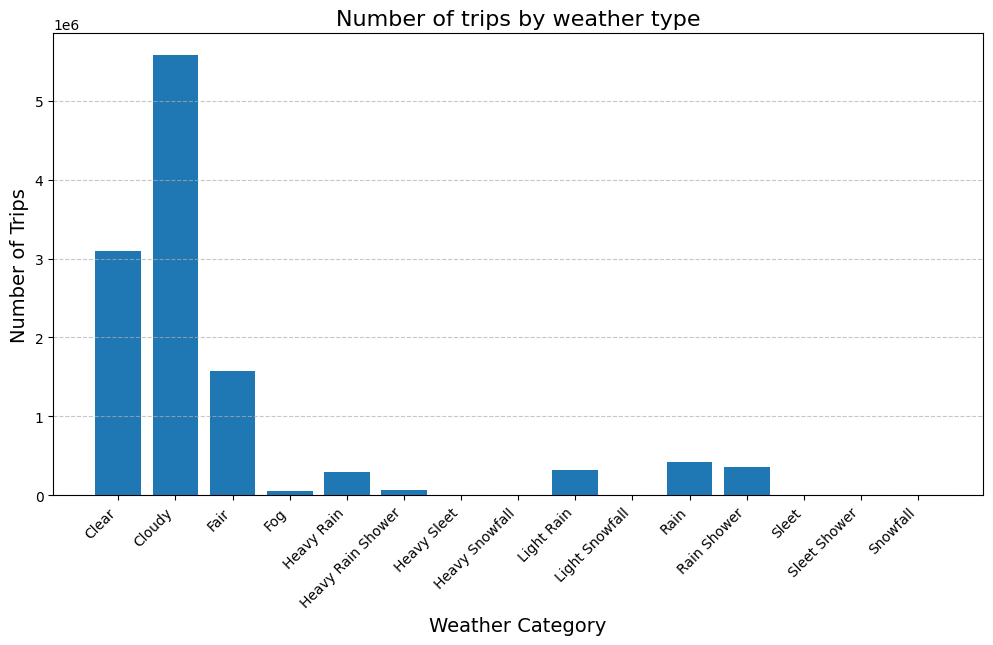

In [50]:
# Group data by Weather Category
weather_stats = bixi_2023.groupby('Weather Category').agg(
    num_trips=('STARTSTATIONNAME', 'count'),
    median_trip_length=('trip_length_minutes', 'median')
).reset_index()

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(weather_stats['Weather Category'], weather_stats['num_trips'])
# plt.bar(weather_stats['Weather Category'], weather_stats['median_trip_length'])
plt.title('Number of trips by weather type', fontsize=16)
plt.xlabel('Weather Category', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()

This chart indicates that more trips were made on clear/cloudy/fair days instead of rainy days. While this could be that people don't want to ride in the rain, it could also be a result of there being less rainy days than clear or cloudy days. Looking at trip length also doesn't tell us much, as people that bother to go outside to ride in the rain probably don't care about how long they have to ride, just that they have to get somewhere.

# Learning Models

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np


categorical_columns = ['STARTSTATIONNAME', 'ENDSTATIONNAME', 
                       'Weather Category', 'Month of Year']
numeric_columns = ['Population', 'distance_to_center']

# Clean the dataset by dropping rows with missing values in relevant columns
bixi_data_clean = bixi_2023.dropna(subset=categorical_columns + numeric_columns + ['trip_length_minutes'])

# Split into features (X) and target (y)
X = bixi_data_clean[categorical_columns + numeric_columns]
y = bixi_data_clean['trip_length_minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),  # OneHotEncode categorical columns
        ('num', StandardScaler(), numeric_columns)     # Scale numeric columns
    ])

model = SGDRegressor()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Model R^2 score on test data:", score)

Model R^2 score on test data: 0.00026038854956422774


Really doesn't perform very well, perhaps trying to estimate trip length is not the best way to solve the problem.

New Dataset for predicting number of trips based on month and weather category:

In [52]:
# Extract day and month from 'STARTTIME'
bixi_2023['day'] = bixi_2023['STARTTIME'].dt.day
bixi_2023['month'] = bixi_2023['STARTTIME'].dt.month
bixi_2023['day_of_week'] = bixi_2023['STARTTIME'].dt.day_of_week

# The below code is for the event that Montreal experiences multiple weather codes in one day. Since we just want to aggregate by day and station and not by weather code,
# We get the most frequent weather code for a given day/station.

# Step 1: Compute most frequent weather category for each group
most_frequent_weather = (
    bixi_2023.groupby(['day', 'month', 'STARTSTATIONARRONDISSEMENT', 'STARTSTATIONNAME', 'distance_to_center', 'Weather Category'])
    .size()
    .reset_index(name='weather_count')
    .sort_values(['day', 'month', 'STARTSTATIONARRONDISSEMENT', 'STARTSTATIONNAME', 'distance_to_center', 'weather_count'], ascending=False)
)

# Keep only the top weather category for each group
most_frequent_weather = (
    most_frequent_weather.groupby(['day', 'month', 'STARTSTATIONARRONDISSEMENT', 'STARTSTATIONNAME', 'distance_to_center'])
    .first()  # First row after sorting by count
    .reset_index()
)

# Step 2: Create the trip summary
trip_summary = bixi_2023.groupby(['day', 'month', 'STARTSTATIONARRONDISSEMENT', 'STARTSTATIONNAME', 'distance_to_center']).size().reset_index(name='num_trips')

# Step 3: Merge the two DataFrames
trip_summary = pd.merge(trip_summary, most_frequent_weather, on=['day', 'month', 'STARTSTATIONARRONDISSEMENT', 'STARTSTATIONNAME', 'distance_to_center'], how='left')


In [53]:


categorical_columns = ['month', 'Weather Category']

# Clean the dataset by dropping rows with missing values in relevant columns
bixi_data_clean = trip_summary.dropna(subset=categorical_columns + ['num_trips'])

# Split into features (X) and target (y)
X = bixi_data_clean[categorical_columns]
y = bixi_data_clean['num_trips']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_columns)]  # OneHotEncode categorical columns
)

model = LinearRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('regressor', model)])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Model R^2 score on test data:", score)

Model R^2 score on test data: 0.06785034487430208


In [54]:

categorical_columns = ['month', 'Weather Category', 'STARTSTATIONARRONDISSEMENT', 'STARTSTATIONNAME']
numeric_columns = ['distance_to_center']

# Clean the dataset by dropping rows with missing values in relevant columns
bixi_data_clean = trip_summary.dropna(subset=categorical_columns + numeric_columns + ['num_trips'])

# Split into features (X) and target (y)
X = bixi_data_clean[categorical_columns + numeric_columns]
y = bixi_data_clean['num_trips']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])
model = SGDRegressor()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Model R^2 score on test data:", score)

# Compute additional metrics
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Model R^2 score on test data: 0.8013749205372525
Mean Absolute Error (MAE): 18.97368261382499
Mean Squared Error (MSE): 838.6777779005401
Root Mean Squared Error (RMSE): 28.959934010638563


In [55]:
# Define the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1) # No noticeable improvements after 500, maybe a lot higher would be better?

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Model R^2 score on test data:", score)

# Compute additional metrics
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Model R^2 score on test data: 0.8615771035187076
Mean Absolute Error (MAE): 14.744917662471877
Mean Squared Error (MSE): 584.4790977327716
Root Mean Squared Error (RMSE): 24.176002517636608


In [56]:

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
score = pipeline.score(X_test, y_test)
print("Model R^2 score on test data:", score)

# Compute additional metrics
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Model R^2 score on test data: 0.7108733654022217
Mean Absolute Error (MAE): 24.081560158936405
Mean Squared Error (MSE): 1220.8130612722484
Root Mean Squared Error (RMSE): 34.940135392872314


The random forest model performs the best by a good margin, which indicates that interactions between features is more important.